In [1]:
import os
import nltk
import re
import datetime
from functools import lru_cache
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import pickle
#from google.colab import files
import io
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from ray.tune.sklearn import TuneGridSearchCV
from ray.tune.sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier
import ray
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from math import sqrt

C:\Users\szymon\scoop\apps\python310\current\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ray.init()

2023-02-03 21:07:35,690	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.2.0


In [3]:
# remove any instance of <...> or numbers
REMOVAL_REGEX = re.compile(r"<.*?>|[0-9]")
SENTIMENT_POS = 1
SENTIMENT_NEG = 0
SENTIMENT_DICT = {0: "Negative", 1: "Positive"}

In [4]:
# Google Collab
#uploaded = files.upload()
#all_reviews_df = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset.csv']))
# Local Files
# Not much point in reading the file if we use pickles anyway
all_reviews_df = pd.read_csv("./data/IMDB Dataset.csv")

# EDA

In [5]:
all_reviews_df.info()
all_reviews_df['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [6]:
encoder = preprocessing.LabelEncoder()
all_reviews_df["sentiment"] = encoder.fit_transform(all_reviews_df["sentiment"])
all_reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
all_reviews_df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

# Pre-Processing

In [8]:
# Set up SpaCy
# You may need to run `python -m pip install 'spacy[transformers,lookups]'`
# You may need to run `python -m pip install spacy[cuda-autodetect]
# That is assuming you have a CUDA supported GPU (nVidia and AMD apparently support it)
# Otherwise it falls back to CPU.
# You can also do spacy.require_gpu(), however that will throw an error if it is not supported.
# If this returns False and you want it to be True, check if you installed `nvcc`, the Nvidia CUDA compiler.
# Also, you need to set the CUDA_PATH environment variable to where you installed the CUDA toolkit
# That may be done automatically if you install all components of the nVidia CUDA Toolkit though.
# Also, if this returns false, check if you did `python -m pip install cupy`
# (this will take a _while_) as you will be compiling some things with nvidia cuda compiler
# OR, as an alternative, I think you can do `python -m pip install cupy-wheel` OR
# `python -m pip installl cupy-cuda12x`
# This might be annoying depending on your GPU driver version.
# Actually, on an i7-6700k @4.7GHz, running it on the CPU took 1200 seconds to process 50k reviews
# With the help of the GPU, it actually took 1560 seconds. Somehow.
# On my laptop with an i7-6820HQ, it took double that time.
#print("Preferring GPU:",spacy.prefer_gpu())

# You need to run `python -m spacy download en_core_web_sm` or `python -m spacy download en_core_web_lg`
# Otherwise you get an error
# nlp = spacy.load("en_core_web_lg") # Potentially slower, but with more data.
nlp = spacy.load("en_core_web_sm")

In [9]:
preprocess_start_time = datetime.datetime.now()

In [10]:
# Add some stopwords that weren't caught after preprocessing
STOP_WORDS.add("s")
#STOP_WORDS.add("il")
#STOP_WORDS.add("ve")
#STOP_WORDS.add("ll")
#STOP_WORDS.add("t")
# Potentially crucial, but was not done initially.
# The pickled reviews were pre-processed without calling this, therefore some of the reviews
# Can be misclassified as they are missing these words.
STOP_WORDS.remove("not")
STOP_WORDS.remove("no")

@lru_cache(maxsize=51200)
def is_alpha_cached(token):
    return token.is_alpha

# Take in a row from a pandas dataframe
# And return a list of lemmatized words with no stop words, numbers, etc.

# We can't really create a cache here.
# As all reviews will be different.
# @lru_cache(maxsize=51200)
# I've noticed that preprocessing removes words like `not` which is not optimal.
# We could have removed `not` from STOP_WORDS.
def preprocess_review(review):
    review = REMOVAL_REGEX.sub(" ", review.lower())
    doc = nlp(review)
    # return " ".join(w.lemma_ for w in doc if (w.text not in STOP_WORDS and w.lemma_ not in STOP_WORDS) and is_alpha_cached(w))
    return " ".join(w.lemma_ for w in doc if ((w.text not in STOP_WORDS) and is_alpha_cached(w)))

In [11]:
# This step takes a **long** time (around 30-35 minutes on my machine.)
# Becasue of that, I have included the pickle file which can be used instead
PICKLE_POS = "./processed_positive_reviews.pickle"
PICKLE_NEG = "./processed_negative_reviews.pickle"
if os.path.isfile(PICKLE_POS):
    with open(PICKLE_POS, "rb") as pickle_file:
        print("Loading positive reviews from pickle")
        processed_positive_reviews = pickle.load(pickle_file)
else:
    print("Processing positive reviews from scratch")
    processed_positive_reviews = [preprocess_review(review) for _index, (review, sentiment) in all_reviews_df.iterrows() if sentiment == SENTIMENT_POS]
    with open(PICKLE_POS, "wb") as pickle_file:
        print("Writing positive reviews to pickle")
        pickle.dump(processed_positive_reviews, pickle_file)
    
if os.path.isfile(PICKLE_NEG):
    with open(PICKLE_NEG, "rb") as pickle_file:
        print("Loading negative reviews from pickle")
        processed_negative_reviews = pickle.load(pickle_file)
else:
    print("Processing negative reviews from scratch")
    processed_negative_reviews = [preprocess_review(review) for _index, (review, sentiment) in all_reviews_df.iterrows() if sentiment == SENTIMENT_NEG]
    with open(PICKLE_NEG, "wb") as pickle_file:
        print("Writing positive reviews to pickle")
        pickle.dump(processed_negative_reviews, pickle_file)

Loading positive reviews from pickle
Loading negative reviews from pickle


In [12]:
print("Sample processed positive review:\n", processed_positive_reviews[0], "\n----")
print("Sample processed negative review:\n", processed_negative_reviews[0], "\n----")

Sample processed positive review:
 reviewer mention watch oz episode hook right exactly happen thing strike oz brutality unflinche scene violence set right word trust faint hearted timid pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inward privacy high agenda em city home aryan muslim gangsta latinos christians italian irish scuffle death stare dodgy dealing shady agreement far away main appeal fact go show dare forget pretty picture paint mainstream audience forget charm forget romance oz mess episode see strike nasty surreal ready watch develop taste oz get accustomed high level graphic violence violence injustice crooked guard sell nickel inmate kill order away mannered middle class inmate turn prison bitch lack street skill prison experience watch oz comfortable uncomfortable viewing that touch dark 
----
Sample processed negati

In [13]:
# We actually need to split the data 50/50
# To ensure that we have an even split of positive/negative reviews for training/testing
# We will split the data manually and then shuffle it.
SPLIT = 12500

random.shuffle(processed_positive_reviews)
random.shuffle(processed_negative_reviews)

reviews_train = processed_positive_reviews[:SPLIT] + processed_negative_reviews[:SPLIT]
sentiments_train = [SENTIMENT_POS] * SPLIT + [SENTIMENT_NEG] * SPLIT

reviews_test = processed_positive_reviews[SPLIT:25000] + processed_negative_reviews[SPLIT:25000]
sentiments_test = [SENTIMENT_POS] * SPLIT + [SENTIMENT_NEG] * SPLIT

# There is no need to shuffle it as train_test_split does it for us.

all_reviews = processed_positive_reviews + processed_negative_reviews
all_labels = [SENTIMENT_POS] * len(processed_positive_reviews) + [SENTIMENT_NEG] * len(processed_negative_reviews)

len(reviews_train), len(reviews_test), len(sentiments_train), len(sentiments_test)

(25000, 25000, 25000, 25000)

In [14]:
print("Sample train review:\n", reviews_train[0], "\nSentiment:", sentiments_train[0], "\n---")
print("Sample test review:\n", reviews_test[0], "\nSentiment:", sentiments_test[0], "\n---")

Sample train review:
 rate film average screenplay direction production value acting rating turn calculate screen character play heroine ella raine carol richman excellent commend thomas gomez inspector burgess character convince personally think guilty verdict scott henderson alan curtis view naive form alliance prove scott alibi film suevia film noir cine negro dvd spanish la dama desconocida original soundtrack ingle alternative language despite search find wholly english anxious performance ella raine impressed performance heroine impact play sole female garage ella perform heroic role believe innocence engineer boss refuse suggestion return home kansas boss pet solve missing fact secretly love boss little hard believe formally formal business relationship design child home playground suppose family man light carol brain film code operation producer portray sex metaphor form furious drumming play elisha cooke doll girl easy virtue attempt lure drummer give information phantom lady 

In [15]:
print("Pre-processing the data took: ", (datetime.datetime.now() - preprocess_start_time).total_seconds())

Pre-processing the data took:  0.170052


# Vectorizers

## TF-IDF Vectorizer

In [16]:
PICKLE_TFIDF_VECT = "./tfidf_vectorizer.pickle"

if os.path.isfile(PICKLE_TFIDF_VECT):
    with open(PICKLE_TFIDF_VECT, "rb") as pickle_file:
        print("Loading TF-IDF Vectorizer from pickle")
        tfidf_vectorizer = pickle.load(pickle_file)
    tfidf_features = tfidf_vectorizer.transform(reviews_train)
else:
    print("Creating tf-idf vectorizer from scratch")
    # It turns out that tfidfVectorizer can actually preprocess our input
    # It might be easier to do that than using spacy
    # However I did not explore the potential performance difference
    # I wonder what the best value for this is
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    tfidf_features = tfidf_vectorizer.fit_transform(reviews_train)
    with open(PICKLE_TFIDF_VECT, "wb") as pickle_file:
        print("Writing TF-IDF Vectorizer to pickle")
        pickle.dump(tfidf_vectorizer, pickle_file)

Loading TF-IDF Vectorizer from pickle


## Unigram Vectorizer

In [17]:
PICKLE_UNIGRAM_VECT = "./unigram_vectorizer.pickle"

if os.path.isfile(PICKLE_UNIGRAM_VECT):
    with open(PICKLE_UNIGRAM_VECT, "rb") as pickle_file:
        print("Loading Unigram Vectorizer from pickle")
        unigram_vectorizer = pickle.load(pickle_file)
    unigram_features = unigram_vectorizer.transform(reviews_train)
else:
    print("Creating unigram vectorizer from scratch")
    unigram_vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=10000)
    unigram_features = unigram_vectorizer.fit_transform(reviews_train)
    with open(PICKLE_UNIGRAM_VECT, "wb") as pickle_file:
        print("Writing unigram vectorizer to pickle")
        pickle.dump(unigram_vectorizer, pickle_file)

Loading Unigram Vectorizer from pickle


## Bigram Vectorizer

In [18]:
PICKLE_BIGRAM_VECT = "./bigram_vectorizer.pickle"

if os.path.isfile(PICKLE_BIGRAM_VECT):
    with open(PICKLE_BIGRAM_VECT, "rb") as pickle_file:
        print("Loading Bigram Vectorizer from pickle")
        bigram_vectorizer = pickle.load(pickle_file)
    bigram_features = bigram_vectorizer.transform(reviews_train)
else:
    print("Creating bigram vectorizer from scratch")
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=15000)
    bigram_features = bigram_vectorizer.fit_transform(reviews_train)
    with open(PICKLE_BIGRAM_VECT, "wb") as pickle_file:
        print("Writing bigram vectorizer to pickle")
        pickle.dump(bigram_vectorizer, pickle_file)

Loading Bigram Vectorizer from pickle


## Trigram Vectorizer

In [19]:
PICKLE_TRIGRAM_VECT = "./trigram_vectorizer.pickle"

if os.path.isfile(PICKLE_TRIGRAM_VECT):
    with open(PICKLE_TRIGRAM_VECT, "rb") as pickle_file:
        print("Loading Trigram Vectorizer from pickle")
        trigram_vectorizer = pickle.load(pickle_file)
    trigram_features = trigram_vectorizer.transform(reviews_train)
else:
    print("Creating trigram vectorizer from scratch")
    trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=20000)
    trigram_features = trigram_vectorizer.fit_transform(reviews_train)
    with open(PICKLE_TRIGRAM_VECT, "wb") as pickle_file:
        print("Writing trigram vectorizer to pickle")
        pickle.dump(trigram_vectorizer, pickle_file)

Loading Trigram Vectorizer from pickle


# Creating The Models

In [20]:
sample_negative_review = "Horrible. I wanted the movie to end as quickly as possible. Waste of time and money, and the acting was not good either."
sample_positive_review = "This movie is great! I really, really loved it. Best movie I experienced in cinemas recently."

# .transform takes in a list of strings
# eg. ["This movie is banging!"]

print("Sample TF-IDF processed review:\n", tfidf_vectorizer.transform([sample_negative_review]), "\n----")
print("Sample Unigram processed review:\n", unigram_vectorizer.transform([sample_negative_review]), "\n----")
print("Sample Bigram processed review:\n", bigram_vectorizer.transform([sample_negative_review]), "\n----")
print("Sample Trigram processed review:\n", trigram_vectorizer.transform([sample_negative_review]), "\n----")

Sample TF-IDF processed review:
   (0, 87)	0.39841977055095673
  (0, 57)	0.2995195311612519
  (0, 31)	0.36286292688956506
  (0, 16)	0.521041357497608
  (0, 1)	0.5902509101672396 
----
Sample Unigram processed review:
   (0, 78)	1
  (0, 2924)	1
  (0, 3798)	1
  (0, 4294)	1
  (0, 5861)	1
  (0, 5935)	1
  (0, 6169)	1
  (0, 6838)	1
  (0, 7120)	1
  (0, 9072)	1
  (0, 9099)	1
  (0, 9729)	1 
----
Sample Bigram processed review:
  
----
Sample Trigram processed review:
  
----


In [21]:
# These steps can take a few minutes as well.
# In the future: Add these into pickles
tfidf_vectorized_test_reviews = tfidf_vectorizer.transform(reviews_test)

In [22]:
unigram_vectorized_test_reviews = unigram_vectorizer.transform(reviews_test)

In [23]:
bigram_vectorized_test_reviews = bigram_vectorizer.transform(reviews_test)

In [24]:
trigram_vectorized_test_reviews = trigram_vectorizer.transform(reviews_test)

## Hyper-Parameter Tuning

In [25]:
def display_hyperparams(cv_results):
    print("Best Parameters:", cv_results.best_params_)
    cv_mean_score = cv_results.cv_results_["mean_test_score"]
    cv_std_score = cv_results.cv_results_["std_test_score"]
    cv_params = cv_results.cv_results_["params"]
    for mean, std, params in zip(cv_mean_score, cv_std_score, cv_params):
        # The values have a lot of decimal places
        print(round(mean, 2), "\t+-\t", round(std, 2), "\tfor", params)

In [26]:
# Out of the 25k reviews for training, we can do hyperparameter tuning by taking let's say 20k for training, and 5k for testing

# I think this can be done in a better way
# What I do now is a little funky.

# total training reviews = 25k
# [12500 * positive] + [12500 * negative]
# What we want to do is:
# training = [10000 * positive] + [10000 * negative]
# testing = [2500 * positive] + [2500 * negative]
# Honestly, this should have been implemented in a better data structure than primitive lists.
# That's a "to-do" for future me.

# Keep in mind, the reviews are shuffled, but the order of positive and negative reviews are constant
kfold_reviews_train = reviews_train[:10000] + reviews_train[12500:22500]
kfold_sentiments_train = sentiments_train[:10000] + sentiments_train[12500:22500]

kfold_reviews_test = reviews_train[10000:12500] + reviews_train[22500:25000]
kfold_sentiments_test = sentiments_train[10000:12500] + sentiments_train[22500:25000]

print("Positive Train Reviews:", len([s for s in kfold_sentiments_train if s == SENTIMENT_POS]))
print("Negative Train Reviews:", len([s for s in kfold_sentiments_train if s == SENTIMENT_NEG]))
print("Positive Test Reviews:", len([s for s in kfold_sentiments_test if s == SENTIMENT_POS]))
print("Negative Test Reviews:", len([s for s in kfold_sentiments_test if s == SENTIMENT_NEG]))

len(kfold_reviews_train), len(kfold_reviews_test), len(kfold_sentiments_train), len(kfold_sentiments_test)

Positive Train Reviews: 10000
Negative Train Reviews: 10000
Positive Test Reviews: 2500
Negative Test Reviews: 2500


(20000, 5000, 20000, 5000)

### Naive Bayes
Naive Bayes does not have any hyper-parameters we can tune.

### Support Vector Machine

In [27]:
# Naive Bayes doesn't have any hyper-parameters (actually, it has `alpha`...)
# So we start off with SVM
hyper_svm = SGDClassifier()
hyper_svm_params = {
    #"epsilon" : [0.01]
    "alpha": [1e-7, 1e-4, 1e-1, 1],
    "epsilon": [0.01, 0.1, 0.25, 0.5, 1]
    # Used for svm.SVC() and not for SGDClassifier()
    #"kernel": ["linear", "rbf"],
    #"C": [0.1, 1, 2, 5, 10] # How harshly are wrong answers punished
}

# We can stick n_jobs = -1 here to ensure all CPU cores are used
# We can also run these on the GPU with the use_gpu=True flag
svm_cv = TuneGridSearchCV(
    hyper_svm, hyper_svm_params, early_stopping=True, max_iters=10, use_gpu=True
)
svm_cv.fit(tfidf_vectorizer.transform(kfold_reviews_train), kfold_sentiments_train)
display_hyperparams(svm_cv)
# The above svm_cv.best_params will be used in our models later on.

# Then see what results we get
# This should be in a function. Ah well.
svm_hyper_pred = svm_cv.predict(tfidf_vectorizer.transform(kfold_reviews_test))
print("Accuracy:", accuracy_score(kfold_sentiments_test, svm_hyper_pred))
print("Confusion Matrix:", "\n----\n", confusion_matrix(kfold_sentiments_test, svm_hyper_pred), "\n----")
print(classification_report(kfold_sentiments_test, svm_hyper_pred))

Best Parameters: {'alpha': 0.0001, 'epsilon': 1}
0.67 	+-	 0.02 	for {'alpha': 1e-07, 'epsilon': 0.01}
0.74 	+-	 0.0 	for {'alpha': 0.0001, 'epsilon': 0.01}
0.7 	+-	 0.01 	for {'alpha': 0.1, 'epsilon': 0.01}
0.6 	+-	 0.04 	for {'alpha': 1, 'epsilon': 0.01}
0.66 	+-	 0.01 	for {'alpha': 1e-07, 'epsilon': 0.1}
0.74 	+-	 0.01 	for {'alpha': 0.0001, 'epsilon': 0.1}
0.68 	+-	 0.02 	for {'alpha': 0.1, 'epsilon': 0.1}
0.67 	+-	 0.02 	for {'alpha': 1, 'epsilon': 0.1}
0.66 	+-	 0.02 	for {'alpha': 1e-07, 'epsilon': 0.25}
0.74 	+-	 0.0 	for {'alpha': 0.0001, 'epsilon': 0.25}
0.7 	+-	 0.01 	for {'alpha': 0.1, 'epsilon': 0.25}
0.6 	+-	 0.03 	for {'alpha': 1, 'epsilon': 0.25}
0.66 	+-	 0.02 	for {'alpha': 1e-07, 'epsilon': 0.5}
0.73 	+-	 0.01 	for {'alpha': 0.0001, 'epsilon': 0.5}
0.69 	+-	 0.02 	for {'alpha': 0.1, 'epsilon': 0.5}
0.61 	+-	 0.04 	for {'alpha': 1, 'epsilon': 0.5}
0.66 	+-	 0.01 	for {'alpha': 1e-07, 'epsilon': 1}
0.74 	+-	 0.0 	for {'alpha': 0.0001, 'epsilon': 1}
0.69 	+-	 0.02 	for

### K-Nearest Neighbours

In [28]:
# This can take a few minutes to complete.
# If you want, you can skip this. I ran it a few times and it consistently returned 19 as the best value.
# That's also mentioned later when running the final model.
hyper_knn = KNeighborsClassifier()
hyper_knn_params = {
    # I deleted 1, 2, 3 and 5 from this list
    # That is because I have tested it with 9, and it was better
    # Therefore we can reduce the computational complexity a little.
    "n_neighbors": [7, 9, 11, 13, 15, 17, 19]
}

knn_cv = TuneGridSearchCV(
    hyper_knn, hyper_knn_params, early_stopping=False, max_iters=1
)

knn_cv.fit(tfidf_vectorizer.transform(kfold_reviews_train), kfold_sentiments_train)
display_hyperparams(knn_cv)

knn_hyper_pred = knn_cv.predict(tfidf_vectorizer.transform(kfold_reviews_test))
print("Accuracy:", accuracy_score(kfold_sentiments_test, knn_hyper_pred))
print("Confusion Matrix:", "\n----\n", confusion_matrix(kfold_sentiments_test, knn_hyper_pred), "\n----")
print(classification_report(kfold_sentiments_test, knn_hyper_pred))

Best Parameters: {'n_neighbors': 19}
0.68 	+-	 0.0 	for {'n_neighbors': 7}
0.68 	+-	 0.0 	for {'n_neighbors': 9}
0.68 	+-	 0.0 	for {'n_neighbors': 11}
0.69 	+-	 0.01 	for {'n_neighbors': 13}
0.69 	+-	 0.01 	for {'n_neighbors': 15}
0.69 	+-	 0.0 	for {'n_neighbors': 17}
0.7 	+-	 0.0 	for {'n_neighbors': 19}
Accuracy: 0.6892
Confusion Matrix: 
----
 [[1661  839]
 [ 715 1785]] 
----
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      2500
           1       0.68      0.71      0.70      2500

    accuracy                           0.69      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.69      0.69      0.69      5000



### N-Grams
As the N-Grams in this project utilise the same model as Naive Bayes, there are no hyper-parameters to tune.

## Final Models

### Naive Bayes

In [29]:
naive_bayes_model = MultinomialNB()
print("Training naive bayes model...")
naive_bayes_model.fit(tfidf_features, sentiments_train)

Training naive bayes model...


MultinomialNB()

#### Own Predictions

In [30]:
# You can run more manual predictions here
bayes_pred = naive_bayes_model.predict(tfidf_vectorizer.transform([sample_positive_review, sample_negative_review]))
for p in bayes_pred:
    print(SENTIMENT_DICT[p])

Positive
Negative


#### Testing Dataset

In [31]:
bayes_predictions = naive_bayes_model.predict(tfidf_vectorized_test_reviews)
print(accuracy_score(sentiments_test, bayes_predictions))
print(confusion_matrix(sentiments_test, bayes_predictions))
print(classification_report(sentiments_test, bayes_predictions))

0.73152
[[8978 3522]
 [3190 9310]]
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     12500
           1       0.73      0.74      0.74     12500

    accuracy                           0.73     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.73      0.73      0.73     25000



#### ROC, AUC, MSE and RMSE

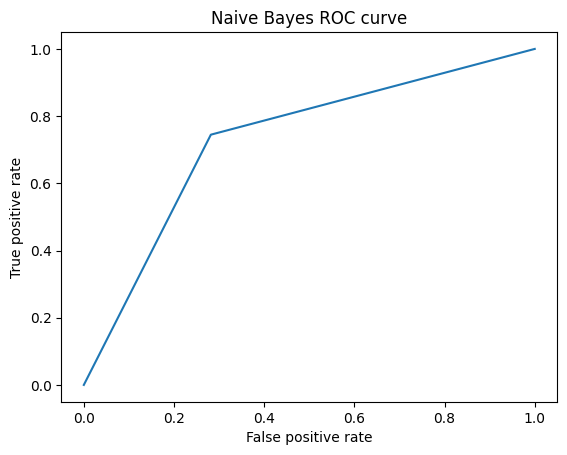

Naive Bayes AUC: 0.7315200000000001
Naive Bayes MSE: 0.26848
Naive Bayes RMSE: 0.5181505572707609


In [32]:
# Receiver Operating Characteristic curve
fpr, tpr, thresholds = roc_curve(sentiments_test, bayes_predictions)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Naive Bayes ROC curve")
plt.show()

# AUC
auc = roc_auc_score(sentiments_test, bayes_predictions)
print("Naive Bayes AUC:", auc)

# Mean Squared Error
mse = mean_squared_error(sentiments_test, bayes_predictions)
print("Naive Bayes MSE:", mse)
print("Naive Bayes RMSE:", sqrt(mse))

### Support Vector Machine

In [33]:
# Let's get the best hyper-parameters automatically
# If this fails etc. A set of params that I got when running this notebook was:
# Best Parameters: {'alpha': 0.0001, 'epsilon': 1}
svm_model = SGDClassifier(epsilon=svm_cv.best_params_["epsilon"], alpha=svm_cv.best_params_["alpha"])
svm_model.fit(tfidf_features, sentiments_train)

SGDClassifier(epsilon=1)

#### Own Predictions

In [34]:
svm_pred = svm_model.predict(tfidf_vectorizer.transform([sample_positive_review, sample_negative_review]))
for p in svm_pred:
    print(SENTIMENT_DICT[p])

Positive
Positive


#### Testing Dataset

In [35]:
svm_predictions = svm_model.predict(tfidf_vectorized_test_reviews)
print(accuracy_score(sentiments_test, svm_predictions))
print(confusion_matrix(sentiments_test, svm_predictions))
print(classification_report(sentiments_test, svm_predictions))

0.74456
[[9037 3463]
 [2923 9577]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     12500
           1       0.73      0.77      0.75     12500

    accuracy                           0.74     25000
   macro avg       0.75      0.74      0.74     25000
weighted avg       0.75      0.74      0.74     25000



#### ROC, AUC, MSE and RMSE

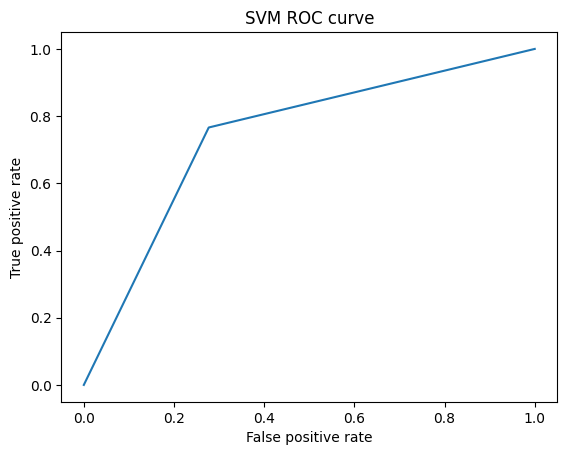

SVM AUC: 0.74456
SVM MSE: 0.25544
SVM RMSE: 0.5054107240650915


In [36]:
# Receiver Operating Characteristic curve
fpr, tpr, thresholds = roc_curve(sentiments_test, svm_predictions)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("SVM ROC curve")
plt.show()

# AUC
auc = roc_auc_score(sentiments_test, svm_predictions)
print("SVM AUC:", auc)

# Mean Squared Error
mse = mean_squared_error(sentiments_test, svm_predictions)
print("SVM MSE:", mse)
print("SVM RMSE:", sqrt(mse))

### K-Nearest Neighbours

In [37]:
# Let's get the param automatically after running hyper-parameter tuning
# If that fails, let's use 19 as that's the best value I got when I tested it
knn_model = KNeighborsClassifier(n_neighbors=knn_cv.best_params_["n_neighbors"])
knn_model.fit(tfidf_features, sentiments_train)

KNeighborsClassifier(n_neighbors=19)

#### Own Predictions

In [38]:
knn_pred = knn_model.predict(tfidf_vectorizer.transform([sample_positive_review, sample_negative_review]))
for p in knn_pred:
    print(SENTIMENT_DICT[p])

Positive
Negative


#### Testing Dataset

In [39]:
knn_predictions = knn_model.predict(tfidf_vectorized_test_reviews)
print(accuracy_score(sentiments_test, knn_predictions))
print(confusion_matrix(sentiments_test, knn_predictions))
print(classification_report(sentiments_test, knn_predictions))

0.69776
[[8216 4284]
 [3272 9228]]
              precision    recall  f1-score   support

           0       0.72      0.66      0.69     12500
           1       0.68      0.74      0.71     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000



#### ROC, AUC, MSE and RMSE

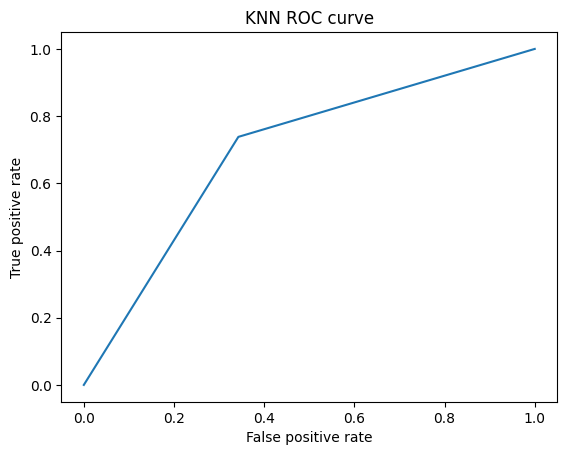

KNN AUC: 0.6977599999999999
KNN MSE: 0.30224
KNN RMSE: 0.5497635855529175


In [40]:
# Receiver Operating Characteristic curve
fpr, tpr, thresholds = roc_curve(sentiments_test, knn_predictions)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("KNN ROC curve")
plt.show()

# AUC
auc = roc_auc_score(sentiments_test, knn_predictions)
print("KNN AUC:", auc)

# Mean Squared Error
mse = mean_squared_error(sentiments_test, knn_predictions)
print("KNN MSE:", mse)
print("KNN RMSE:", sqrt(mse))

### N-gram Model
Note to self: There is no actual unigram model. We use Naive Bayes for this.

#### Unigram Model

In [41]:
unigram_model = MultinomialNB()
unigram_model.fit(unigram_vectorized_test_reviews, sentiments_train)

MultinomialNB()

##### Own Predictions

In [42]:
unigram_pred = unigram_model.predict(unigram_vectorizer.transform([sample_positive_review, sample_negative_review]))
for p in unigram_pred:
    print(SENTIMENT_DICT[p])

Positive
Negative


##### Testing Dataset

In [43]:
unigram_predictions = unigram_model.predict(unigram_vectorized_test_reviews)
print(accuracy_score(sentiments_test, unigram_predictions))
print(confusion_matrix(sentiments_test, unigram_predictions))
print(classification_report(sentiments_test, unigram_predictions))

0.86632
[[11005  1495]
 [ 1847 10653]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.85      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



#### ROC, AUC, MSE and RMSE

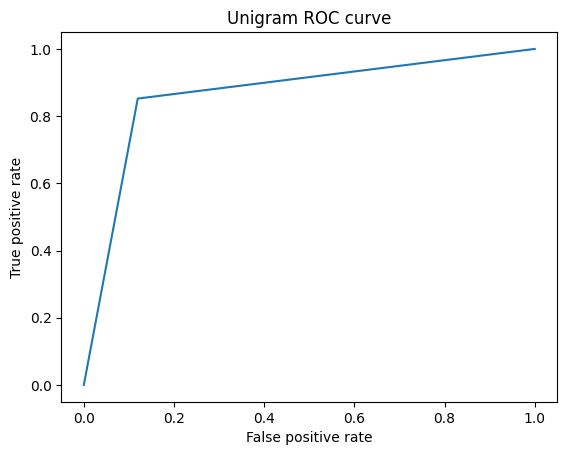

Unigram AUC: 0.8663200000000001
Unigram MSE: 0.13368
Unigram RMSE: 0.36562275640337266


In [44]:
# Receiver Operating Characteristic curve
fpr, tpr, thresholds = roc_curve(sentiments_test, unigram_predictions)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Unigram ROC curve")
plt.show()

# AUC
auc = roc_auc_score(sentiments_test, unigram_predictions)
print("Unigram AUC:", auc)

# Mean Squared Error
mse = mean_squared_error(sentiments_test, unigram_predictions)
print("Unigram MSE:", mse)
print("Unigram RMSE:", sqrt(mse))

#### Bigram Model

In [45]:
bigram_model = MultinomialNB()
bigram_model.fit(bigram_vectorized_test_reviews, sentiments_train)

MultinomialNB()

##### Own Predictions

In [46]:
bigram_pred = bigram_model.predict(bigram_vectorizer.transform([sample_positive_review, sample_negative_review]))
for p in bigram_pred:
    print(SENTIMENT_DICT[p])

Negative
Negative


##### Testing Dataset

In [47]:
bigram_predictions = bigram_model.predict(bigram_vectorized_test_reviews)
print(accuracy_score(sentiments_test, bigram_predictions))
print(confusion_matrix(sentiments_test, bigram_predictions))
print(classification_report(sentiments_test, bigram_predictions))

0.88056
[[10825  1675]
 [ 1311 11189]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12500
           1       0.87      0.90      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



#### ROC, AUC, MSE and RMSE

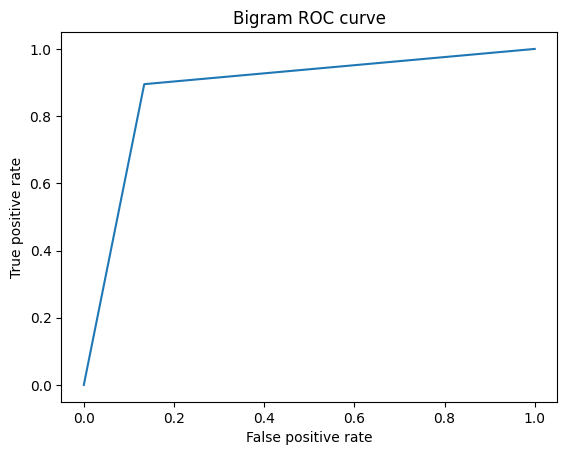

Bigram AUC: 0.88056
Bigram MSE: 0.11944
Bigram RMSE: 0.34560092592468555


In [48]:
# Receiver Operating Characteristic curve
fpr, tpr, thresholds = roc_curve(sentiments_test, bigram_predictions)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Bigram ROC curve")
plt.show()

# AUC
auc = roc_auc_score(sentiments_test, bigram_predictions)
print("Bigram AUC:", auc)

# Mean Squared Error
mse = mean_squared_error(sentiments_test, bigram_predictions)
print("Bigram MSE:", mse)
print("Bigram RMSE:", sqrt(mse))

#### Trigram Model

In [49]:
trigram_model = MultinomialNB()
trigram_model.fit(trigram_vectorized_test_reviews, sentiments_train)

MultinomialNB()

##### Own Predictions

In [50]:
trigram_pred = trigram_model.predict(trigram_vectorizer.transform([sample_positive_review, sample_negative_review]))
for p in trigram_pred:
    print(SENTIMENT_DICT[p])

Negative
Negative


##### Testing Dataset

In [51]:
trigram_predictions = trigram_model.predict(trigram_vectorized_test_reviews)
print(accuracy_score(sentiments_test, trigram_predictions))
print(confusion_matrix(sentiments_test, trigram_predictions))
print(classification_report(sentiments_test, trigram_predictions))

0.7998
[[10889  1611]
 [ 3394  9106]]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81     12500
           1       0.85      0.73      0.78     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



#### ROC, AUC, MSE and RMSE

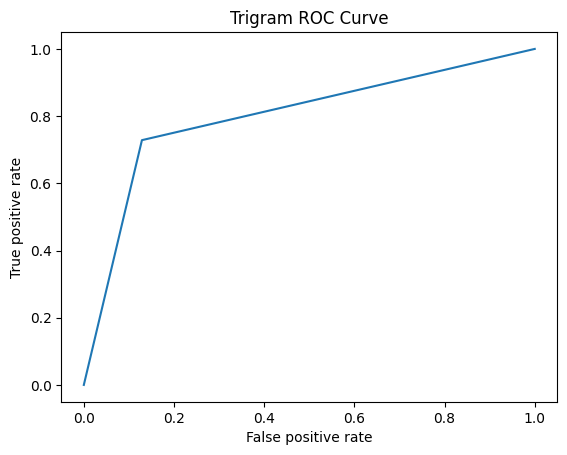

Trigram AUC: 0.7998
Trigram MSE: 0.2002
Trigram RMSE: 0.44743714642394183


In [52]:
# Receiver Operating Characteristic curve
fpr, tpr, thresholds = roc_curve(sentiments_test, trigram_predictions)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Trigram ROC Curve")
plt.show()

# AUC
auc = roc_auc_score(sentiments_test, trigram_predictions)
print("Trigram AUC:", auc)

# Mean Squared Error
mse = mean_squared_error(sentiments_test, trigram_predictions)
print("Trigram MSE:", mse)
print("Trigram RMSE:", sqrt(mse))

## ROC Curves for All Models

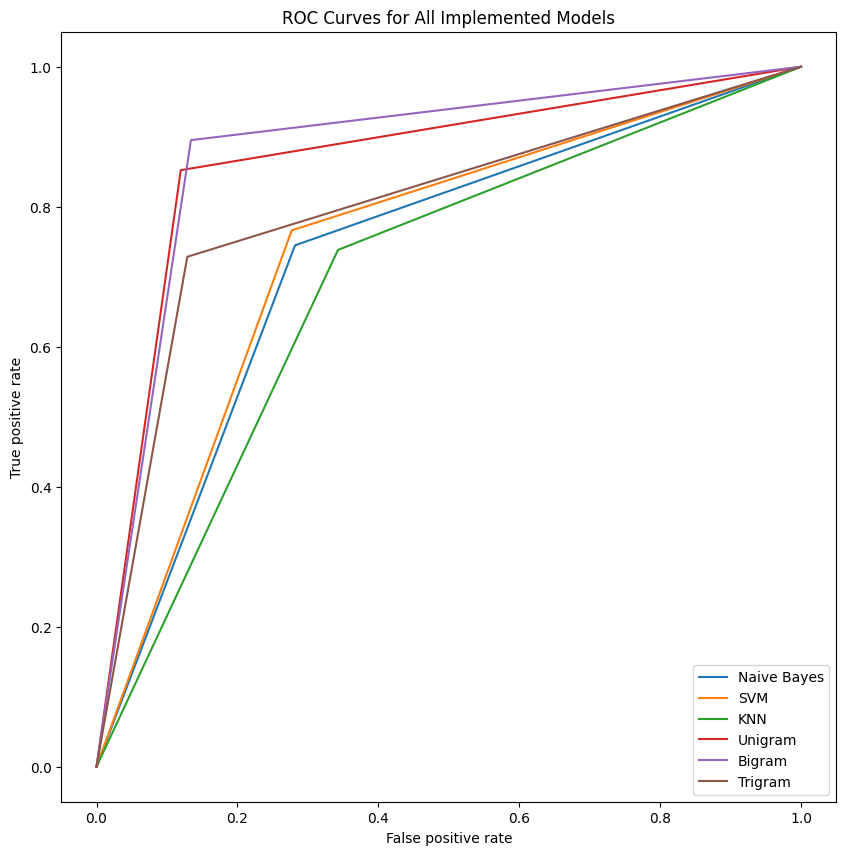

In [62]:
plt.figure(figsize=(10, 10))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

all_preds = {
    "Naive Bayes": bayes_predictions,
    "SVM": svm_predictions,
    "KNN": knn_predictions,
    "Unigram": unigram_predictions,
    "Bigram": bigram_predictions,
    "Trigram": trigram_predictions
}

for _index, value in enumerate(all_preds):
    fpr, tpr, thresholds = roc_curve(sentiments_test, all_preds[value])
    plt.plot(fpr, tpr)
    
plt.legend(["Naive Bayes", "SVM", "KNN", "Unigram", "Bigram", "Trigram"])
plt.title("ROC Curves for All Implemented Models")
plt.show()

## Learning Curves for All Models
### Future Work

In [ ]:
#fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharey=True)

#common_params = {
#    "X": trigram_vectorized_test_reviews,
#    "y": sentiments_train,
#    "train_sizes": np.linspace(0.1, 1.0, 5),
#    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
#    "score_type": "both",
#    "n_jobs": 4,
#    "line_kw": {"marker": "o"},
#    "std_display_style": "fill_between",
#    "score_name": "Accuracy",
#}
#
##for ax_idx, estimator in enumerate([naive_bayes_model, svm_model, knn_model, unigram_model, bigram_model, trigram_model]):
#for ax_idx, estimator in enumerate([naive_bayes_model, svm_model, knn_model]):
#    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
#    handles, label = ax[ax_idx].get_legend_handles_labels()
#    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
#    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")